In [1]:
import numpy
import urllib
import scipy.optimize
import random
from collections import defaultdict
import nltk
import string
from nltk.stem.porter import *
from sklearn import linear_model
import xgboost as xgb
import pandas as pd
pd.set_option('display.max_colwidth', -1)
from sklearn.metrics import accuracy_score ,confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline 
from collections import Counter

In [2]:
for l in open('News_Category_Dataset.json'):
    print l
    break

{"short_description": "She left her husband. He killed their children. Just another day in America.", "headline": "There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV", "date": "2018-05-26", "link": "https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89", "authors": "Melissa Jeltsen", "category": "CRIME"}



In [3]:
def readjson(f):
  for l in open(f):
    yield eval(l)

In [4]:
data=readjson('News_Category_Dataset.json')
data=list(data)

### Exploratory data analysis

In [5]:
data_df=pd.read_json('News_Category_Dataset.json', lines=True)

In [31]:
data_df.shape

(124989, 6)

### The data has ~125k instances with the following attributes:

In [36]:
data_df.columns.tolist()

[u'authors', u'category', u'date', u'headline', u'link', u'short_description']

In [33]:
data_df.head()

,authors,category,date,headline,link,short_description
0,Melissa Jeltsen,CRIME,2018-05-26,"There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV",https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89,She left her husband. He killed their children. Just another day in America.
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song,https://www.huffingtonpost.com/entry/will-smith-joins-diplo-and-nicky-jam-for-the-official-2018-world-cup-song_us_5b09726fe4b0fdb2aa541201,Of course it has a song.
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-grant-marries_us_5b09212ce4b0568a880b9a8c,The actor and his longtime girlfriend Anna Eberstein tied the knot in a civil ceremony.
3,Ron Dicker,ENTERTAINMENT,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And Democrats In New Artwork,https://www.huffingtonpost.com/entry/jim-carrey-adam-schiff-democrats_us_5b0950e8e4b0fdb2aa53e675,The actor gives Dems an ass-kicking for not fighting hard enough against Donald Trump.
4,Ron Dicker,ENTERTAINMENT,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags To Pick Up After Her Dog,https://www.huffingtonpost.com/entry/julianna-margulies-trump-poop-bag_us_5b093ec2e4b0fdb2aa53df70,"The ""Dietland"" actress said using the bags is a ""really cathartic, therapeutic moment."""


### Distribution of the categories by %

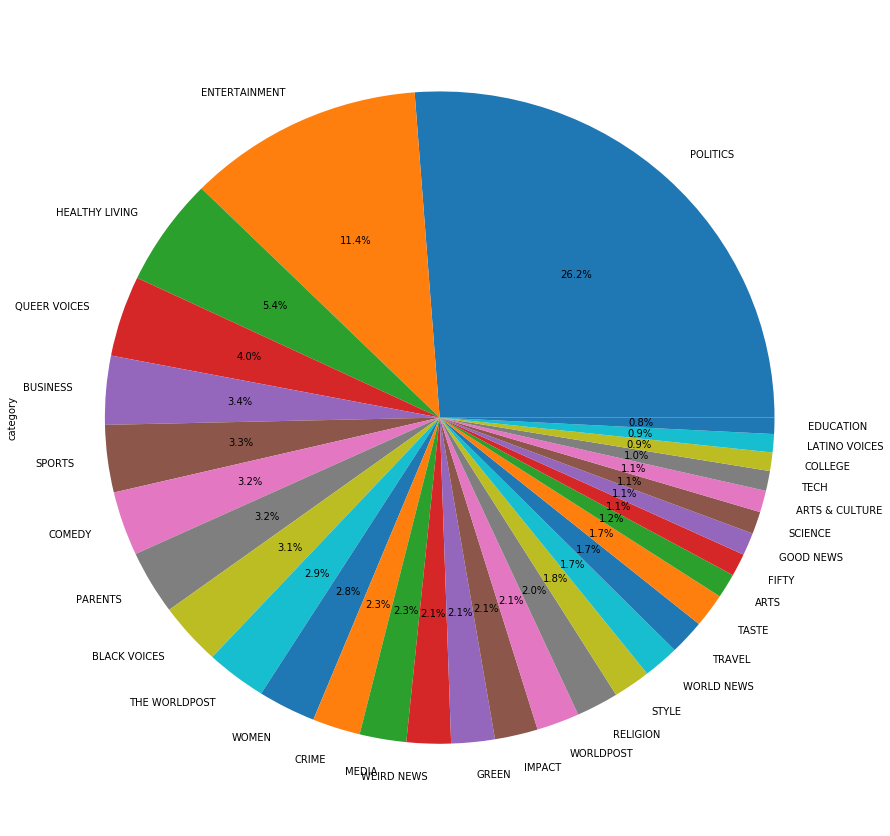

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
data_df['category'].value_counts().plot.pie( autopct = '%1.1f%%')

In [26]:
import nltk
from nltk.corpus import stopwords
sw = set(stopwords.words('english'))
punctuation = set(string.punctuation)
#print (sw)
#print punctuation

#### Extract words in headline and short description with counts

In [20]:
data_headline=[]
data_short_desc=[]
wordCount_headline = defaultdict(int)
wordCount_short_desc = defaultdict(int)
for d in data:
  for w in d['short_description'].split():
    if (w.lower() not in sw)  and (h.lower() not in punctuation):
      data_short_desc.append(w.lower())
      wordCount_short_desc[w.lower()]+=1
  for h in d['headline'].split():
    if (h.lower() not in sw) and (h.lower() not in punctuation):
      data_headline.append(h.lower())
      wordCount_headline[h.lower()]+=1

#### Save 1000 most frequent words

In [22]:
counts = [(wordCount_headline[w], w) for w in wordCount_headline]
counts.sort()
counts.reverse()
words = [x[1] for x in counts[:1000]]
wr = open('headline_words.txt','w')

for j in words:
    wr.write(j + " ")
wr.close()

In [27]:
counts = [(wordCount_short_desc[w], w) for w in wordCount_headline]
counts.sort()
counts.reverse()
words = [x[1] for x in counts[:1000]]
wr = open('short_desc_words.txt','w')

for j in words:
    wr.write(j + " ")
wr.close()

### most common words in headline

<img src="wordle_headline.png" alt="Markdown Monster icon" rotate="-90" style="float: left; margin-right: 20px;" />

### most common words in the description

<img src="wordle_short_desc.png" alt="Markdown Monster icon" rotate="-90" style="float: left; margin-right: 20px;" />

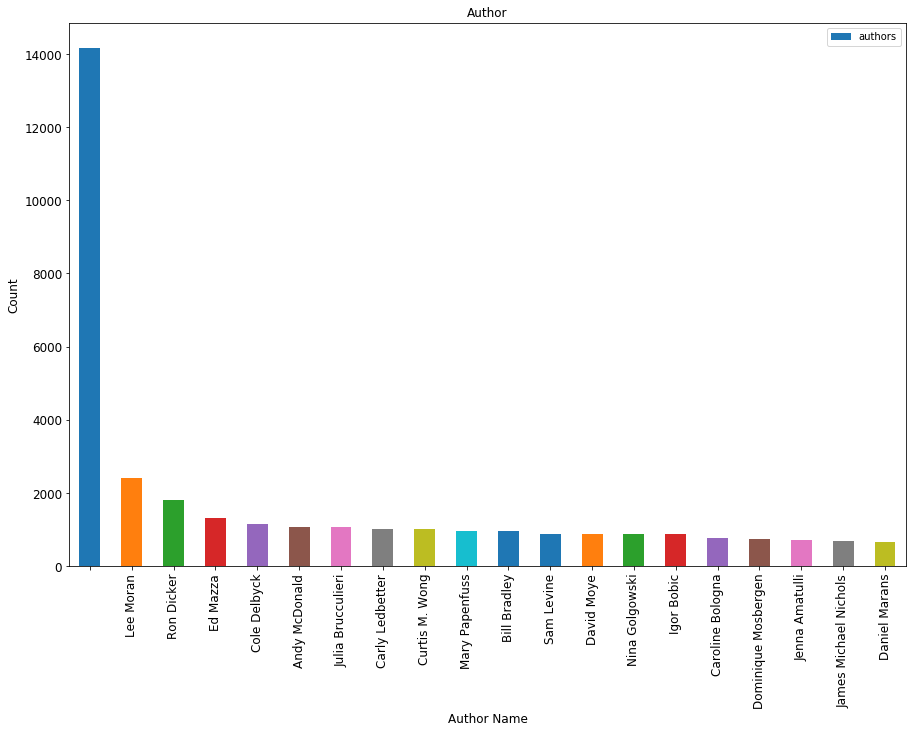

In [17]:
#data_df['authors'].value_counts()
#fig, ax = plt.subplots(1, 1, figsize=(15,15))
#data_df['authors'].value_counts()
#plt.figure()
#data_df['authors'].value_counts().plot(kind='bar');

ax = data_df['authors'].value_counts().head(20).plot(kind='bar', title ="Author", figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("Author Name", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

### Model

In [5]:
wordCount = defaultdict(int)
for d in data:
  for w in d['short_description'].split():
    wordCount[w] += 1
  for h in d['headline'].split():
    wordCount[h] += 1

In [6]:
print len(wordCount)

201182


In [8]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in data:
  r = ''.join([c for c in d['short_description'].lower() if not c in punctuation])
  h = ''.join([c for c in d['headline'].lower() if not c in punctuation])
  for w in r.split():
    wordCount[w] += 1
  for hl in h.split():
    wordCount[hl] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

In [9]:
words = [x[1] for x in counts[:1000]]

In [10]:
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

def feature(datum):
  feat = [0]*len(words)
  r = ''.join([c for c in datum['short_description'].lower() if not c in punctuation])
  h = ''.join([c for c in datum['headline'].lower() if not c in punctuation])
  for w in r.split():
    if w in words:
      feat[wordId[w]] += 1
  for hl in h.split():
    if hl in words:
      feat[wordId[hl]] += 1
  #feat.append(1) #offset
  return feat


In [11]:
X = [feature(d) for d in data]
y = [d['category'] for d in data]

In [12]:
len(y)

124989

In [13]:
len(X)

124989

In [14]:
len(list(set(y)))

31

In [15]:
ylabel_id = dict(zip(list(set(y)), range(31)) )

In [16]:
ylabel_id

{'ARTS': 7,
 'ARTS & CULTURE': 19,
 'BLACK VOICES': 25,
 'BUSINESS': 0,
 'COLLEGE': 27,
 'COMEDY': 12,
 'CRIME': 2,
 'EDUCATION': 29,
 'ENTERTAINMENT': 1,
 'FIFTY': 8,
 'GOOD NEWS': 15,
 'GREEN': 28,
 'HEALTHY LIVING': 30,
 'IMPACT': 6,
 'LATINO VOICES': 4,
 'MEDIA': 16,
 'PARENTS': 3,
 'POLITICS': 5,
 'QUEER VOICES': 21,
 'RELIGION': 9,
 'SCIENCE': 11,
 'SPORTS': 23,
 'STYLE': 14,
 'TASTE': 24,
 'TECH': 10,
 'THE WORLDPOST': 22,
 'TRAVEL': 20,
 'WEIRD NEWS': 17,
 'WOMEN': 13,
 'WORLD NEWS': 18,
 'WORLDPOST': 26}

In [17]:
dtrain=[ int(ylabel_id[d])  for d in y ]

In [18]:
X_all=numpy.array(X)
dtrain=numpy.array(dtrain)

In [19]:
X_all.shape

(124989, 1000)

In [20]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X_all, dtrain, test_size=0.2, random_state=0) 

In [21]:
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

(99991, 1000)
(24998, 1000)
(99991,)
(24998,)


In [22]:
from sklearn.svm import LinearSVC

model = LinearSVC()
model.fit(X_train,y_train)
y_predict = model.predict(X_test)

In [25]:
accuracy = accuracy_score(y_test,y_predict)*100
print(format(accuracy, '.2f'))

48.05
